<a href="https://colab.research.google.com/github/jyosa/bioinformatica/blob/main/alphaMD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


##AlphaFold con la versión ColabFold v1.5.2



In [11]:
#@title Input protein sequence(s), then hit `Runtime` -> `Run all`
from google.colab import files
import os
import re
import hashlib
import random

from sys import version_info 
python_version = f"{version_info.major}.{version_info.minor}"

def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

Sequencia = 'PIAQIHILEGRSDEQKETLIREVSEAISRSLDAPLTSVRVIITEMAKGHFGIGGELAS:PIAQIHILEGRSDEQKETLIREVSEAISRSLDAPLTSVRVIITEMAKGHFGIGGELAS' #@param {type:"string"}
query_sequence = Sequencia
#@markdown  - si va a simular un complejo, separee cada seccuencia con `:`  (soporta homo- y hetero-oligomerso). por ejemplo **KL...VA:KL...VA** para un homodimero
Nombre = 'test' #@param {type:"string"}
jobname = Nombre
# number of models to use
num_relax = 5 #@param [0, 1, 5] {type:"raw"}
#@markdown - especifique cuántas de las estructuras mejor clasificadas se relajarán usando l campo de fuerza Amber 
template_mode = "none" #@param ["none", "pdb70","custom"]
#@markdown - `none` = no se utiliza información de plantilla. `pdb70` = detectar plantillas en pdb70. `custom` - cargar y buscar plantillas propias (formato PDB o mmCIF)

use_amber = num_relax > 0

# remove whitespaces
query_sequence = "".join(query_sequence.split())

basejobname = "".join(jobname.split())
basejobname = re.sub(r'\W+', '', basejobname)
jobname = add_hash(basejobname, query_sequence)

# check if directory with jobname exists
def check(folder):
  if os.path.exists(folder):
    return False
  else:
    return True
if not check(jobname):
  n = 0
  while not check(f"{jobname}_{n}"): n += 1
  jobname = f"{jobname}_{n}"

# make directory to save results
os.makedirs(jobname, exist_ok=True)

# save queries
queries_path = os.path.join(jobname, f"{jobname}.csv")
with open(queries_path, "w") as text_file:
  text_file.write(f"id,sequence\n{jobname},{query_sequence}")

if template_mode == "pdb70":
  use_templates = True
  custom_template_path = None
elif template_mode == "custom":
  custom_template_path = os.path.join(jobname,f"template")
  os.makedirs(custom_template_path, exist_ok=True)
  uploaded = files.upload()
  use_templates = True
  for fn in uploaded.keys():
    os.rename(fn,os.path.join(custom_template_path,fn))
else:
  custom_template_path = None
  use_templates = False

print("jobname",jobname)
print("sequence",query_sequence)
print("length",len(query_sequence.replace(":","")))

jobname test_bb860_1
sequence PIAQIHILEGRSDEQKETLIREVSEAISRSLDAPLTSVRVIITEMAKGHFGIGGELAS:PIAQIHILEGRSDEQKETLIREVSEAISRSLDAPLTSVRVIITEMAKGHFGIGGELAS
length 116


In [12]:
#@title Instalar dependencias
%%bash -s $use_amber $use_templates $python_version

set -e

USE_AMBER=$1
USE_TEMPLATES=$2
PYTHON_VERSION=$3

if [ ! -f COLABFOLD_READY ]; then
  echo "installing colabfold..."
  # install dependencies
  # We have to use "--no-warn-conflicts" because colab already has a lot preinstalled with requirements different to ours
  pip install -q --no-warn-conflicts "colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold" "tensorflow-cpu==2.11.0"
  pip uninstall -yq jax jaxlib
  pip install -q "jax[cuda]==0.3.25" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
  pip install mdtraj
  pip install nglview


  # for debugging
  ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold
  ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold
  touch COLABFOLD_READY
fi

# setup conda
if [ ${USE_AMBER} == "True" ] || [ ${USE_TEMPLATES} == "True" ]; then
  if [ ! -f CONDA_READY ]; then
    echo "installing conda..."
    wget -qnc https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
    bash Miniconda3-latest-Linux-x86_64.sh -bfp /usr/local 2>&1 1>/dev/null
    rm Miniconda3-latest-Linux-x86_64.sh
    touch CONDA_READY
  fi
fi
# setup template search
if [ ${USE_TEMPLATES} == "True" ] && [ ! -f HH_READY ]; then
  echo "installing hhsuite..."
  conda install -y -q -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python="${PYTHON_VERSION}" 2>&1 1>/dev/null
  touch HH_READY
fi
# setup openmm for amber refinement
if [ ${USE_AMBER} == "True" ] && [ ! -f AMBER_READY ]; then
  echo "installing amber..."
  conda install -y -q -c conda-forge openmm=7.5.1 python="${PYTHON_VERSION}" pdbfixer cryptography==38.0.4 2>&1 1>/dev/null
  touch AMBER_READY
fi

In [13]:
#@markdown ### Opciones de MSA (carga de MSA personalizada, secuencia única, modo de emparejamiento)
msa_mode = "mmseqs2_uniref_env" #@param ["mmseqs2_uniref_env", "mmseqs2_uniref","single_sequence","custom"]
pair_mode = "unpaired_paired" #@param ["unpaired_paired","paired","unpaired"] {type:"string"}
#@markdown - "unpaired_paired" = emparejar secuencias de la misma especie + MSA no emparejado, "unpaired" = MSA separado para cada cadena, "paired": solo use secuencias emparejadas.

# decide which a3m to use
if "mmseqs2" in msa_mode:
  a3m_file = os.path.join(jobname,f"{jobname}.a3m")

elif msa_mode == "custom":
  a3m_file = os.path.join(jobname,f"{jobname}.custom.a3m")
  if not os.path.isfile(a3m_file):
    custom_msa_dict = files.upload()
    custom_msa = list(custom_msa_dict.keys())[0]
    header = 0
    import fileinput
    for line in fileinput.FileInput(custom_msa,inplace=1):
      if line.startswith(">"):
         header = header + 1
      if not line.rstrip():
        continue
      if line.startswith(">") == False and header == 1:
         query_sequence = line.rstrip()
      print(line, end='')

    os.rename(custom_msa, a3m_file)
    queries_path=a3m_file
    print(f"moving {custom_msa} to {a3m_file}")
    
else:
  a3m_file = os.path.join(jobname,f"{jobname}.single_sequence.a3m")
  with open(a3m_file, "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)

In [14]:
#@markdown ### Ajustes avanzados
model_type = "auto" #@param ["auto", "alphafold2_ptm", "alphafold2_multimer_v1", "alphafold2_multimer_v2", "alphafold2_multimer_v3"]
#@markdown - si se selecciona `auto`, utilizará `alphafold2_ptm` para la predicción de monómeros y `alphafold2_multimer_v3` para la predicción de complejos. 
#@markdown Se puede usar cualquiera de los mode_types (independientemente de si la entrada es monomérica o un complejo).
num_recycles = "auto" #@param ["auto", "0", "1", "3", "6", "12", "24", "48"]
recycle_early_stop_tolerance = "auto" #@param ["auto", "0.0", "0.5", "1.0"]
#@markdown - si se selecciona `auto`, usará 20 re-ciclos si `model_type=alphafold2_multimer_v3` (con tol=0.5), todos los demás se usan 3 re-ciclos (con tol=0.0).

#@markdown #### Configuraciones para el muestreo
#@markdown -  permitir los use_dropouts y aumentar el número de semillas para muestrear las predicciones de la incertidumbre del modelo.
#@markdown -  disminuir `max msa` para aumentar la incertidumbre
max_msa = "auto" #@param ["auto", "512:1024", "256:512", "64:128", "32:64", "16:32"]
num_seeds = 1 #@param [1,2,4,8,16] {type:"raw"}
use_dropout = False #@param {type:"boolean"}

num_recycles = None if num_recycles == "auto" else int(num_recycles)
recycle_early_stop_tolerance = None if recycle_early_stop_tolerance == "auto" else float(recycle_early_stop_tolerance)
if max_msa == "auto": max_msa = None

#@markdown #### Guardando los ajustess
save_all = True #@param {type:"boolean"}
save_recycles = False #@param {type:"boolean"}
save_to_google_drive = False #@param {type:"boolean"}
#@markdown -  si se seleccionó la opción save_to_google_drive, el resultado zip se cargará en su Google Drive
dpi = 200 #@param {type:"integer"}
#@markdown - establecer dpi para la resolución de la imagen

if save_to_google_drive:
  from pydrive.drive import GoogleDrive
  from pydrive.auth import GoogleAuth
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  print("You are logged into Google Drive and are good to go!")

#@markdown No olvide presionar `Tiempo de ejecución` -> `Ejecutar todo` después de actualizar el formulario.

2023-03-09 21:43:07,134 Running on GPU
2023-03-09 21:43:07,323 Found 5 citations for tools or databases
2023-03-09 21:43:07,324 Query 1/1: test_bb860_1 (length 116)


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:02 remaining: 00:00]


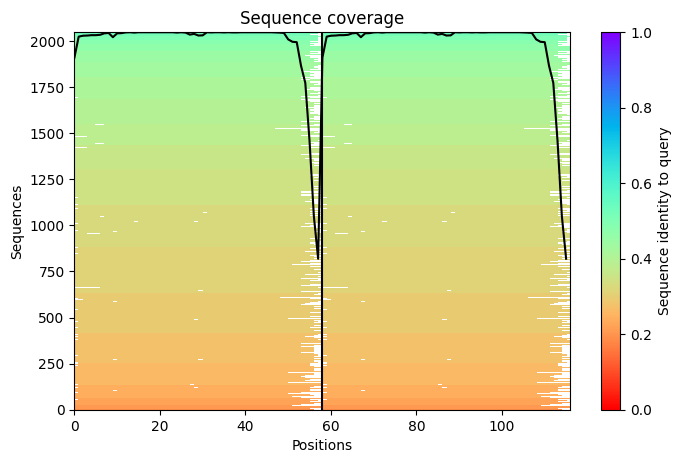

2023-03-09 21:43:10,494 Setting max_seq=508, max_extra_seq=1540
2023-03-09 21:44:06,227 alphafold2_multimer_v3_model_1_seed_000 recycle=0 pLDDT=90.9 pTM=0.841 ipTM=0.829
2023-03-09 21:44:13,670 alphafold2_multimer_v3_model_1_seed_000 recycle=1 pLDDT=94 pTM=0.877 ipTM=0.87 tol=0.353
2023-03-09 21:44:13,671 alphafold2_multimer_v3_model_1_seed_000 took 49.9s (1 recycles)


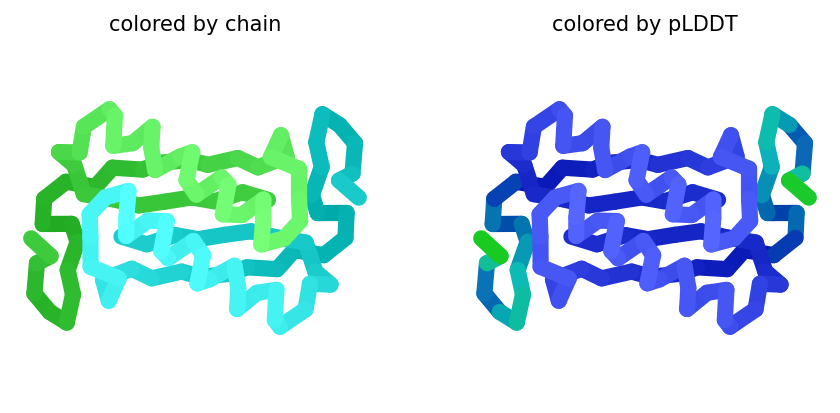

2023-03-09 21:44:21,323 alphafold2_multimer_v3_model_2_seed_000 recycle=0 pLDDT=90.7 pTM=0.839 ipTM=0.832
2023-03-09 21:44:28,879 alphafold2_multimer_v3_model_2_seed_000 recycle=1 pLDDT=93.3 pTM=0.868 ipTM=0.861 tol=0.224
2023-03-09 21:44:28,881 alphafold2_multimer_v3_model_2_seed_000 took 15.0s (1 recycles)


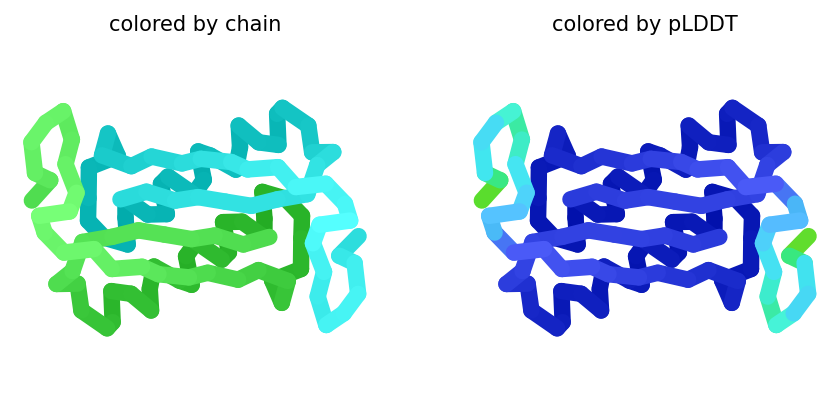

2023-03-09 21:44:36,844 alphafold2_multimer_v3_model_3_seed_000 recycle=0 pLDDT=89.1 pTM=0.821 ipTM=0.815
2023-03-09 21:44:44,565 alphafold2_multimer_v3_model_3_seed_000 recycle=1 pLDDT=92.3 pTM=0.854 ipTM=0.849 tol=0.338
2023-03-09 21:44:44,566 alphafold2_multimer_v3_model_3_seed_000 took 15.3s (1 recycles)


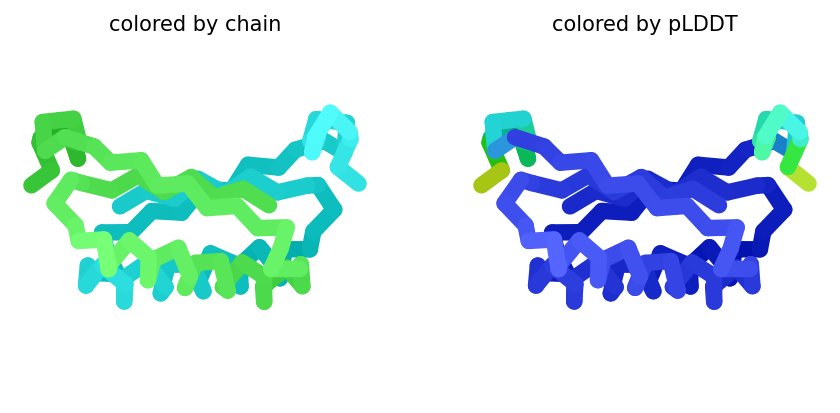

2023-03-09 21:44:52,582 alphafold2_multimer_v3_model_4_seed_000 recycle=0 pLDDT=91.2 pTM=0.836 ipTM=0.832
2023-03-09 21:45:00,375 alphafold2_multimer_v3_model_4_seed_000 recycle=1 pLDDT=93.8 pTM=0.867 ipTM=0.863 tol=0.427
2023-03-09 21:45:00,377 alphafold2_multimer_v3_model_4_seed_000 took 15.6s (1 recycles)


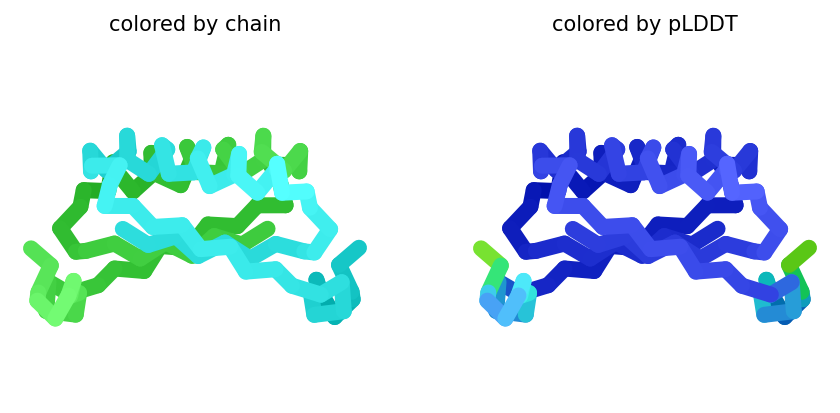

2023-03-09 21:45:08,297 alphafold2_multimer_v3_model_5_seed_000 recycle=0 pLDDT=92.4 pTM=0.863 ipTM=0.854
2023-03-09 21:45:15,976 alphafold2_multimer_v3_model_5_seed_000 recycle=1 pLDDT=95.3 pTM=0.892 ipTM=0.887 tol=0.277
2023-03-09 21:45:15,977 alphafold2_multimer_v3_model_5_seed_000 took 15.4s (1 recycles)


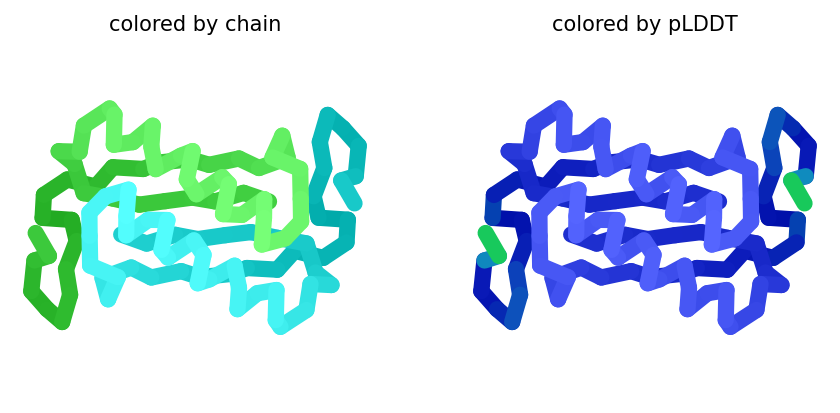

2023-03-09 21:45:16,316 reranking models by 'multimer' metric
2023-03-09 21:45:33,609 Relaxation took 17.3s
2023-03-09 21:45:33,610 rank_001_alphafold2_multimer_v3_model_5_seed_000 pLDDT=95.3 pTM=0.892 ipTM=0.887
2023-03-09 21:45:58,191 Relaxation took 24.6s
2023-03-09 21:45:58,193 rank_002_alphafold2_multimer_v3_model_1_seed_000 pLDDT=94 pTM=0.877 ipTM=0.87
2023-03-09 21:46:14,884 Relaxation took 16.7s
2023-03-09 21:46:14,884 rank_003_alphafold2_multimer_v3_model_4_seed_000 pLDDT=93.8 pTM=0.867 ipTM=0.863
2023-03-09 21:46:32,958 Relaxation took 18.1s
2023-03-09 21:46:32,959 rank_004_alphafold2_multimer_v3_model_2_seed_000 pLDDT=93.3 pTM=0.868 ipTM=0.861
2023-03-09 21:46:53,262 Relaxation took 20.3s
2023-03-09 21:46:53,263 rank_005_alphafold2_multimer_v3_model_3_seed_000 pLDDT=92.3 pTM=0.854 ipTM=0.849
2023-03-09 21:46:54,829 Done


0

In [15]:
#@title Predicciones
mostrar_imagenes = True #@param {type:"boolean"}
display_images = mostrar_imagenes

import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from Bio import BiopythonDeprecationWarning
warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)
from pathlib import Path
from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.plot import plot_msa_v2

import os
import numpy as np
try:
  K80_chk = os.popen('nvidia-smi | grep "Tesla K80" | wc -l').read()
except:
  K80_chk = "0"
  pass
if "1" in K80_chk:
  print("WARNING: found GPU Tesla K80: limited to total length < 1000")
  if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
    del os.environ["TF_FORCE_UNIFIED_MEMORY"]
  if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
    del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

from colabfold.colabfold import plot_protein
from pathlib import Path
import matplotlib.pyplot as plt

# For some reason we need that to get pdbfixer to import
if use_amber and f"/usr/local/lib/python{python_version}/site-packages/" not in sys.path:
    sys.path.insert(0, f"/usr/local/lib/python{python_version}/site-packages/")

def input_features_callback(input_features):  
  if display_images:    
    plot_msa_v2(input_features)
    plt.show()
    plt.close()

def prediction_callback(protein_obj, length,
                        prediction_result, input_features, mode):
  model_name, relaxed = mode
  if not relaxed:
    if display_images:
      fig = plot_protein(protein_obj, Ls=length, dpi=150)
      plt.show()
      plt.close()

result_dir = jobname
if 'logging_setup' not in globals():
    setup_logging(Path(os.path.join(jobname,"log.txt")))
    logging_setup = True

queries, is_complex = get_queries(queries_path)
model_type = set_model_type(is_complex, model_type)

if "multimer" in model_type and max_msa is not None:
  use_cluster_profile = False
else:
  use_cluster_profile = True

download_alphafold_params(model_type, Path("."))
results = run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    custom_template_path=custom_template_path,
    num_relax=num_relax,
    msa_mode=msa_mode,    
    model_type=model_type,
    num_models=5,
    num_recycles=num_recycles,
    recycle_early_stop_tolerance=recycle_early_stop_tolerance,
    num_seeds=num_seeds,
    use_dropout=use_dropout,
    model_order=[1,2,3,4,5],
    is_complex=is_complex,
    data_dir=Path("."),
    keep_existing_results=False,
    rank_by="auto",
    pair_mode=pair_mode,
    stop_at_score=float(100),
    prediction_callback=prediction_callback,
    dpi=dpi,
    zip_results=False,
    save_all=save_all,
    max_msa=max_msa,
    use_cluster_profile=use_cluster_profile,
    input_features_callback=input_features_callback,
    save_recycles=save_recycles,
)
results_zip = f"{jobname}.result.zip"
os.system(f"zip -r {results_zip} {jobname}")

test_bb860_1/test_bb860_1_unrelaxed_rank_001_alphafold2_multimer_v3_model_5_seed_000.pdb


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

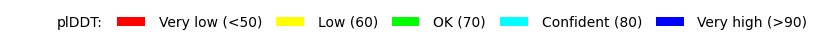

In [16]:
#@title  Representación 3D de las estrcturas {run: "auto"}
import py3Dmol
import glob
import matplotlib.pyplot as plt
from colabfold.colabfold import plot_plddt_legend
from colabfold.colabfold import pymol_color_list, alphabet_list
rank_num = 1 #@param ["1", "2", "3", "4", "5"] {type:"raw"}
color = "lDDT" #@param ["chain", "lDDT", "rainbow"]
mostrar_cadenas_laterales = False #@param {type:"boolean"} 
show_sidechains = mostrar_cadenas_laterales
mostrar_cadena_principal = False #@param {type:"boolean"}
show_mainchains = mostrar_cadena_principal

tag = results["rank"][0][rank_num - 1]
jobname_prefix = ".custom" if msa_mode == "custom" else ""
pdb_filename = f"{jobname}/{jobname}{jobname_prefix}_unrelaxed_{tag}.pdb"
pdb_file = glob.glob(pdb_filename)
print(pdb_filename)
def show_pdb(rank_num=1, show_sidechains=False, show_mainchains=False, color="lDDT"):
  model_name = f"rank_{rank_num}"
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_file[0],'r').read(),'pdb')

  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    chains = len(queries[0][1]) + 1 if is_complex else 1
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})

  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})  
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  return view

show_pdb(rank_num, show_sidechains, show_mainchains, color).show()
if color == "lDDT":
  plot_plddt_legend().show() 


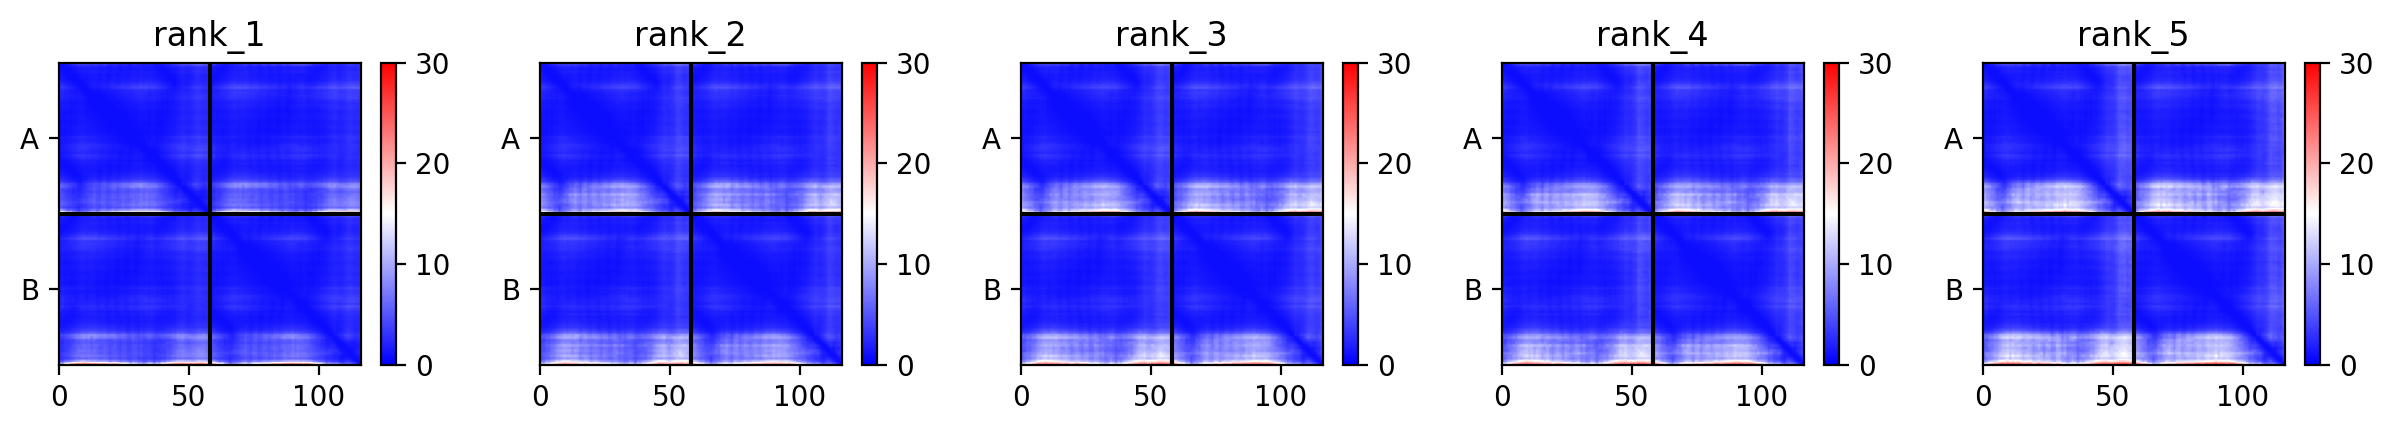
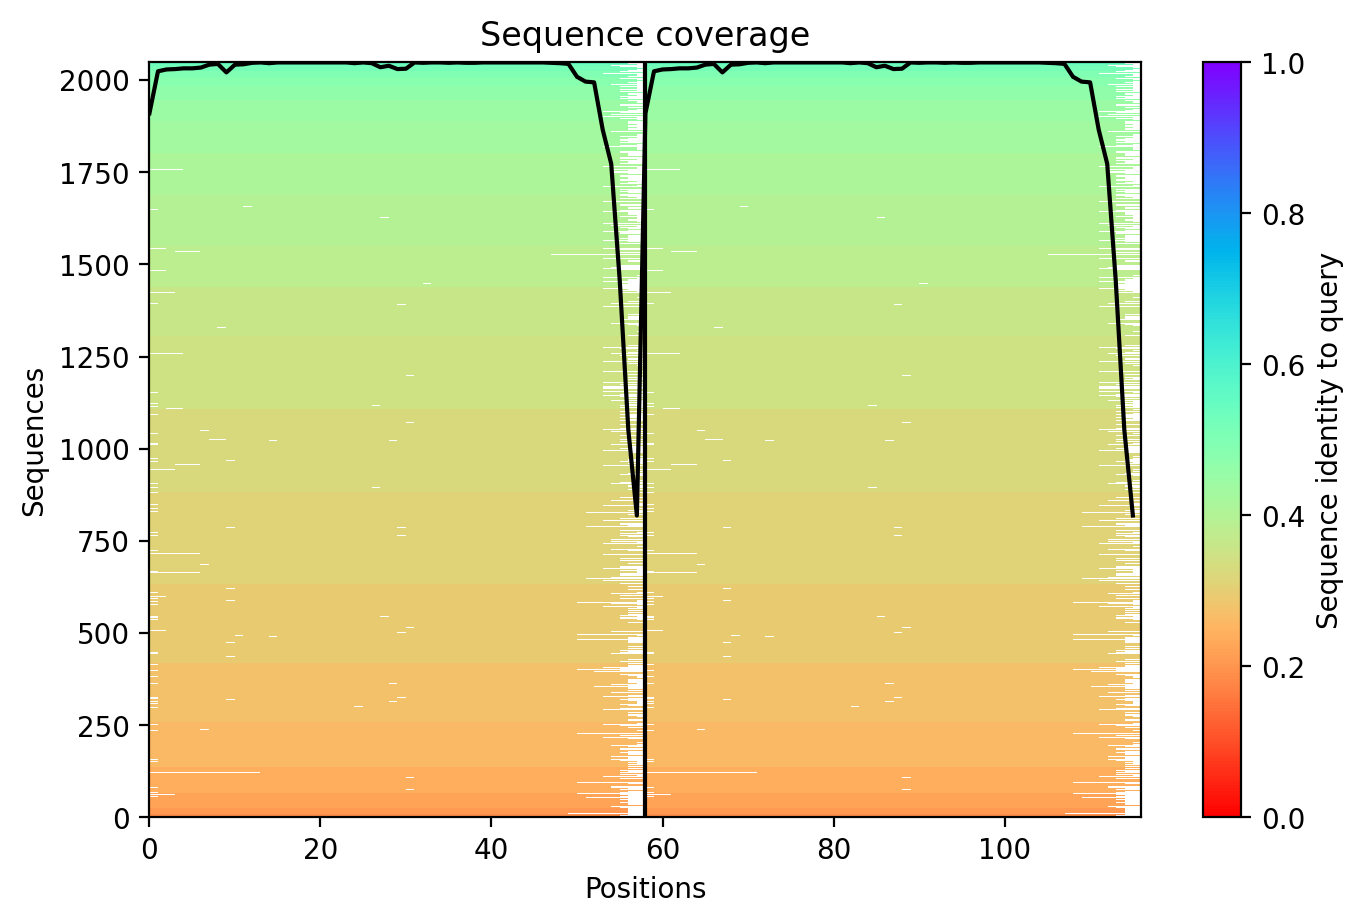
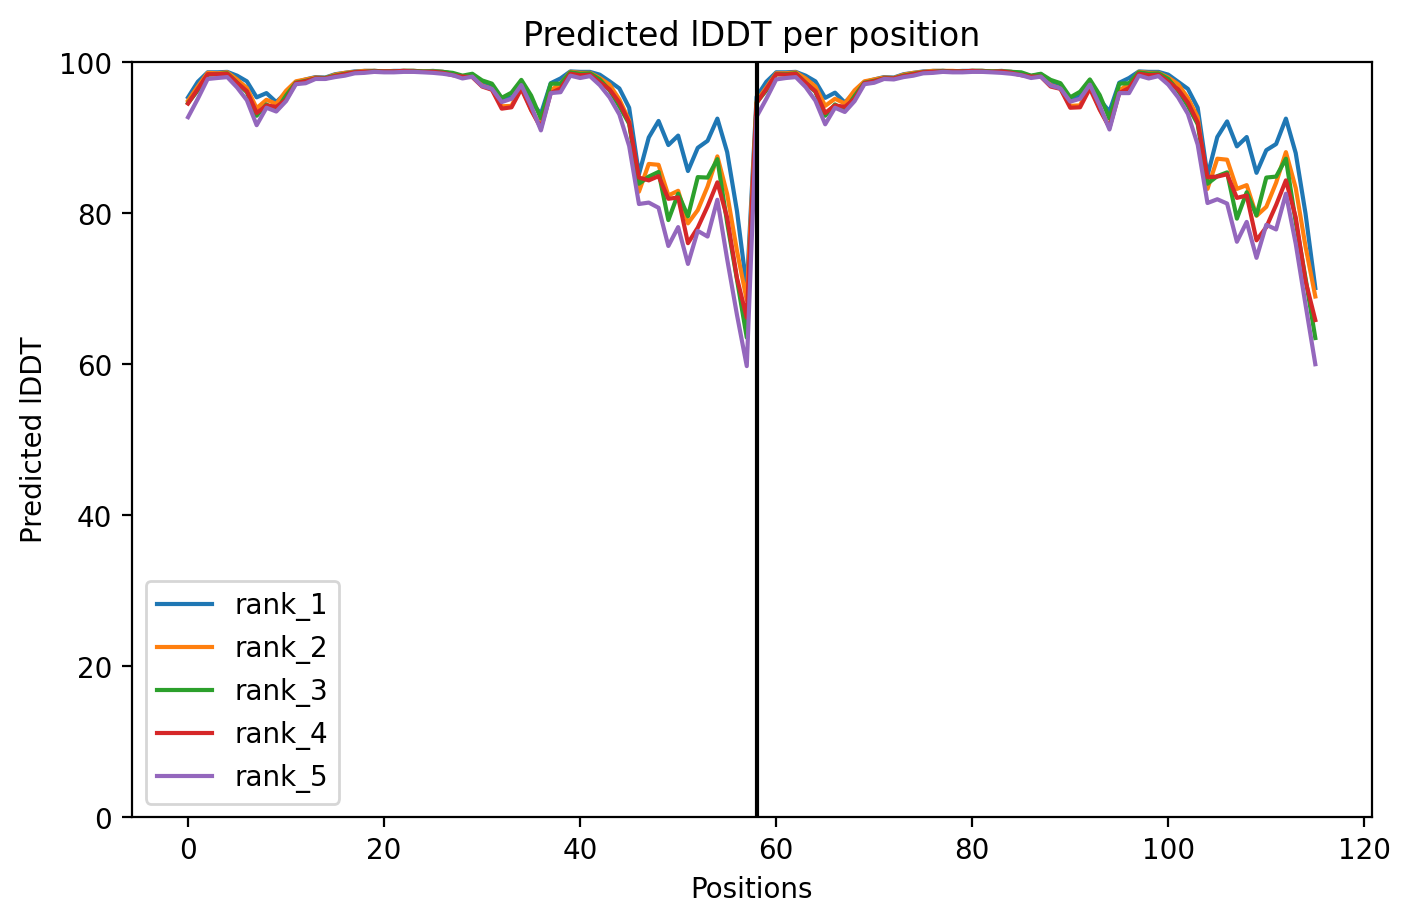

In [17]:
#@title Plots {run: "auto"}
from IPython.display import display, HTML
import base64
from html import escape

# see: https://stackoverflow.com/a/53688522
def image_to_data_url(filename):
  ext = filename.split('.')[-1]
  prefix = f'data:image/{ext};base64,'
  with open(filename, 'rb') as f:
    img = f.read()
  return prefix + base64.b64encode(img).decode('utf-8')

pae = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_pae.png"))
cov = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_coverage.png"))
plddt = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_plddt.png"))
display(HTML(f"""
<style>
  img {{
    float:left;
  }}
  .full {{
    max-width:100%;
  }}
  .half {{
    max-width:50%;
  }}
  @media (max-width:640px) {{
    .half {{
      max-width:100%;
    }}
  }}
</style>
<div style="max-width:90%; padding:2em;">
  <h1>Plots for {escape(jobname)}</h1>
  <img src="{pae}" class="full" />
  <img src="{cov}" class="half" />
  <img src="{plddt}" class="half" />
</div>
"""))


In [18]:
#@title Dinámica Molecular {run: "auto"}
from simtk.openmm.app import *
from simtk.openmm import *
from simtk.unit import *
from sys import stdout
from Bio import PDB
import simtk.openmm.app as app
import pdbfixer

def prepare_protein(pdb_file, ignore_missing_residues=True, ignore_terminal_missing_residues=True):
    """Use pdbfixer to prepare the protein from a PDB file. Hetero atoms such as ligands are 
    removed and non-standard residues replaced. Missing atoms to existing residues are added. 
    Missing residues are ignored by default, but can be included.
    
    Parameters
    ----------
    pdb_file: pathlib.Path or str
        PDB file containing the system to simulate.
    ignore_missing_residues: bool
        If missing residues should be ignored or built.
    ignore_terminal_missing_residues: bool
        If missing residues at the beginning and the end of a chain should be ignored or built.
    
    Returns
    -------
    fixer: pdbfixer.pdbfixer.PDBFixer
        Prepared protein system.
    """
    fixer = pdbfixer.PDBFixer(str(pdb_file))
    fixer.removeHeterogens()  # co-crystallized ligands are unknown to PDBFixer
    fixer.findMissingResidues()  # identify missing residues, needed for identification of missing atoms
    
    # if missing terminal residues shall be ignored, remove them from the dictionary
    if ignore_terminal_missing_residues:  
        chains = list(fixer.topology.chains())
        keys = fixer.missingResidues.keys()
        for key in list(keys):
            chain = chains[key[0]]
            if key[1] == 0 or key[1] == len(list(chain.residues())):
                del fixer.missingResidues[key]
                
    # if all missing residues shall be ignored ignored, clear the dictionary
    if ignore_missing_residues:  
        fixer.missingResidues = {}
        
    fixer.findNonstandardResidues()  # find non-standard residue
    fixer.replaceNonstandardResidues()  # replace non-standard residues with standard one
    fixer.findMissingAtoms()  # find missing heavy atoms
    fixer.addMissingAtoms()  # add missing atoms and residues
    fixer.addMissingHydrogens(7.0)  # add missing hydrogens
    PDBFile.writeFile(fixer.topology, fixer.positions, open('output.pdb', 'w'))
    return fixer

num_nanosegundos = 5.0 #@param {type:"number"}
steps = (num_nanosegundos*1000)/0.002
guardar_frames = 100 #@param {type:"number"}  
#@markdown guardar frame cada n pasos

temperatura = 310.15 #@param {type:"number"}





# prepare protein and build only missing non-terminal residues
prepared_protein = prepare_protein(pdb_filename, ignore_missing_residues=False)
print(prepared_protein)


pdb = PDBFile('output.pdb')
forcefield = ForceField('amber99sb.xml', 'amber99_obc.xml')
print("Building Model..")
modeller = Modeller(pdb.topology, pdb.positions)
print('Adding hydrogens...')
modeller.addHydrogens(forcefield)
print("Creating System")
system = forcefield.createSystem(modeller.topology, constraints=HBonds)
integrator = LangevinIntegrator(temperatura*kelvin, 91/picosecond, 0.002*picoseconds)
platform = Platform.getPlatformByName('CUDA')
platformProperties = {'Precision': 'mixed'}
simulation = Simulation(modeller.topology, system, integrator,platform,platformProperties)
print("Using Platform:", simulation.context.getPlatform().getName())
simulation.context.setPositions(modeller.positions)
# Minimizing System
simulation.minimizeEnergy(maxIterations=0)
# Adding Reporters
namepdbOut = 'simulation_md.pdb'
simulation.reporters.append(PDBReporter(namepdbOut, guardar_frames))
simulation.reporters.append(StateDataReporter('energy.csv', 1000, step=True,
potentialEnergy=True, temperature=True))
# Running simulation
simulation.step(steps)

Building Model..
Adding hydrogens...
Creating System
Using Platform: CUDA


[Text(0.5, 0, 'Time ns'), Text(0, 0.5, 'Potential Energy (kJ/mole)')]

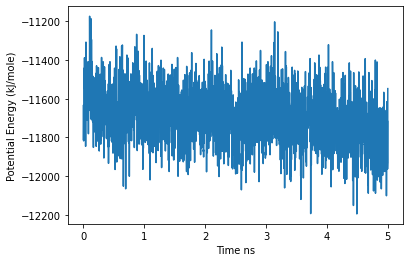

In [21]:
import pandas as pd
import seaborn as sns

df = pd.read_csv('energy.csv')
df['#\"Step\"'] = df['#\"Step\"'].apply(lambda x: x*0.000002)


ax = sns.lineplot(data=df, x="#\"Step\"", y="Potential Energy (kJ/mole)")
ax.set(xlabel='Time ns', ylabel='Potential Energy (kJ/mole)')
